In [1]:
import deepchem as dc

In [2]:
import numpy as np
import tensorflow as tf
from deepchem.data import Dataset, NumpyDataset
from typing import Any, Callable, Dict, Iterable, List, Optional, Sequence, Tuple, Union
from tensorflow.keras.layers import Input, Concatenate, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.python.keras import metrics
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

In [3]:
from IPython import display

In [4]:
tf.__version__

'2.2.0'

In [5]:
conda list deepchem

# packages in environment at c:\users\m.grabski\appdata\local\continuum\anaconda3\envs\deepchem:
#
# Name                    Version                   Build  Channel
deepchem                  2.4.0rc1.dev20200803093024          pypi_0    pypi

Note: you may need to restart the kernel to use updated packages.


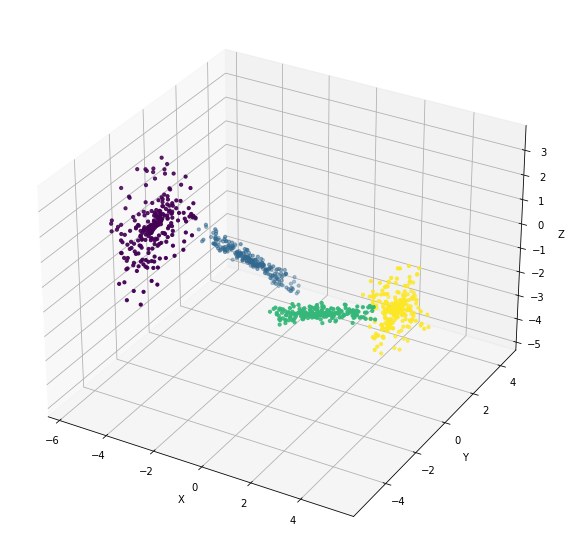

In [28]:
#GENERATE DATAPOINTS 
n_classes = 4
class_centers = np.random.uniform(-4, 4, (n_classes, 3 ))
class_transforms = []
for i in range(n_classes):
    xscale = np.random.uniform(0.5, 2)
    yscale = np.random.uniform(0.5, 2)
    zscale = np.random.uniform(0.5, 2)
    angle = np.random.uniform(0, np.pi)
    m = [[xscale*np.cos(angle), -yscale*np.sin(angle), -zscale*np.sin(angle) ],
         [xscale*np.sin(angle), yscale*np.cos(angle), zscale*np.sin(angle)],
         [xscale*np.sin(angle), -yscale*np.cos(angle), zscale*np.sin(angle)]]
    class_transforms.append(m)
class_transforms = np.array(class_transforms)

def generate_data(n_points):
    classes = np.random.randint(n_classes, size=n_points)
    r = np.random.random(n_points)
    angle = 2*np.pi*np.random.random(n_points)
    phi = np.linspace(0, np.pi, n_points)
    points = (r*np.array([np.cos(angle), np.sin(angle), np.cos(phi)])).T
    points = np.einsum('ijk,ik->ij', class_transforms[classes], points)
    points += class_centers[classes]
    return classes, points



classes, points = generate_data(1000)

%matplotlib inline
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points[:,0],points[:,1], points[:,2], c=classes, s=10)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [46]:
class WGAN():
    """Model based on Ahmed et al. - "Improved Traning of Wasserstein GANs", https://arxiv.org/abs/1704.00028"""
    def __init__(self,
               batch_size=100,
               n_dimensions=2,
               noise_dimensions=10,
               n_critic=5,
               gradient_penalty_weight=10,
               plot_progress=True,
               plot_epoch_interval=100):
        
        self.batch_size = batch_size
        #determines impact of the gradient penalty
        self.gradient_penalty_weight = gradient_penalty_weight
        #how many times critic is trained per generator
        self.n_critic = n_critic
        #noise input dimensions
        self.noise_dim  = noise_dimensions
        #critic input dimensions e.g. 2 = x,y, 3 = x,y,z
        self.dimensions = n_dimensions
        #option used for flexibility, used for class in this example
        self.conditionals = 1
        #should training show plot
        self.plot_progress = plot_progress
        #every how many epochs graph should be updated
        self.plot_progress_inveral= plot_epoch_interval
        #used by critic model
        self.discriminator_input_dim = self.dimensions + self.conditionals
        #because critic uses binary classification
        self.discriminator_output_dim = 1
        #noise model input
        self.generator_input_dim = self.noise_dim + self.conditionals
        #must equal disctriminator/critic input
        self.generator_output_dim = self.discriminator_input_dim

        self.generator_optimizer = self.create_generator_optimizer()
        self.discriminator_optimizer = self.create_discriminator_optimizer()

        self.generator = self.create_generator()
        self.discriminator = self.create_discriminator()

        #create sample noise, can be omitted, currently used for displaying graph
        self.noise = self.generate_noise()
        if self.conditionals >0:
            self.noise_classes = self.generate_noise_conditionals()
            self.noise = tf.concat([self.noise,self.noise_classes],axis=1)


    def create_discriminator(self):
        """Creates discriminator/critic infrastructure, utlises tf.Keras"""

        model = Sequential()
        model.add(Dense(25,  kernel_initializer='he_uniform', input_dim=self.discriminator_input_dim))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dense(15,  kernel_initializer='he_uniform'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dense(10,  kernel_initializer='he_uniform'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dense(5,  kernel_initializer='he_uniform'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dense(self.discriminator_output_dim))
        return model

    def create_generator(self):
        """Creates generator, utlises tf.Keras infrastructure"""
        model = Sequential()
        model.add(Dense(30, kernel_initializer='he_uniform', input_dim=self.generator_input_dim))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dense(15,  kernel_initializer='he_uniform'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dense(10,  kernel_initializer='he_uniform'))
        model.add(LeakyReLU(alpha=0.01))
        model.add(Dense(self.generator_output_dim))
        return model

    def create_generator_optimizer(self, learning_rate=1e-4):
        """Create optimizer for generator"""
        return tf.keras.optimizers.Adam(learning_rate = learning_rate)

    def create_discriminator_optimizer(self,learning_rate=1e-4 ):
        """Create optimizer for discriminator/critic"""
        return tf.keras.optimizers.Adam(learning_rate = learning_rate)   

    @tf.function
    def generate_noise(self):
        """Generate noise input for generator"""
        return tf.random.normal([self.batch_size, self.noise_dim])

    @tf.function
    def generate_noise_conditionals(self):
        """Generate noise conditional for generator"""

      #EXAMPLE CODE THAT CREATES BINARY CLASSES

        #create single binary class in shape format (1,batch_size)
        values = tf.random.categorical([[0.5,0.5]],self.batch_size)
        #reshape into actual input shape, has to match noise dimensions
        values =  tf.reshape(values,(self.batch_size,1))
        #cast into float so can be combined into single input with noise                    
        return tf.cast(values, dtype='float32')

    @tf.function
    def train_generator(self):
        """Method for training generator"""
        #generate noise input data
        noise = self.generate_noise()

        if self.conditionals >0 :
            #generate noise conditionals
            conditions = self.generate_noise_conditionals()
            #combine into single tensor
            noise = tf.concat([noise,conditions],axis=1)

        with tf.GradientTape() as tape:
            #generate fake data
            fake = self.generator(noise, training=True)
            #check how well discriminator predicts fake data
            logits = self.discriminator(fake, training=True)
            loss = -tf.reduce_mean(logits)

        #update gradients
        gradients = tape.gradient(loss,self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))
        return loss

    @tf.function
    def train_discriminator(self, real, real_conditionals):
        """Method for training discriminator aka critic"""

        #check if real input is of correct shape
        assert real.shape == (self.batch_size, self.dimensions), 'Incorrect real data shape, is {} while should be {}'.format(real.shape, (self.batch_size, self.dimensions))

        #generate batch of random noise
        noise = self.generate_noise()

      #make sure that data is of type 'float32'
        if real.dtype is not 'float32':
            real =  tf.cast(real, 'float32')

        if self.conditionals>0:
            #generate noise conditionals
            conditionals = self.generate_noise_conditionals()
            #combine into single tensor
            noise = tf.concat([noise,conditionals],axis=1)

              #make sure that conditionals are also float32, otherwise tf.concat will fail
            if real_conditionals.dtype is not 'float32':
                real_conditionals = tf.cast(real_conditionals, 'float32')

              #check if shape is correct, otherwise tf.concat will fail
            if real_conditionals.shape is not (self.batch_size,self.conditionals):
                real_conditionals = tf.reshape(real_conditionals, (self.batch_size,self.conditionals))

                #combine inputs
                real = tf.concat([real, real_conditionals], axis=1)

        with tf.GradientTape() as tape:
            fake = self.generator(noise, training=True)
            fake_logits = self.discriminator(fake, training=True)
            real_logits = self.discriminator(real, training=True)
            fake_loss = tf.reduce_mean(fake_logits)
            real_loss = tf.reduce_mean(real_logits)
            cost = fake_loss - real_loss
            penalty = self.gradient_penalty(partial(self.discriminator, training=True), real, fake)
            cost += self.gradient_penalty_weight * penalty
        gradients = tape.gradient(cost, self.discriminator.trainable_variables)
        self.discriminator_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))
        return cost

    @tf.function
    def gradient_penalty(self,func, real, fake):
        """loss calculated for discriminator aka critic"""

        alpha = tf.random.uniform([self.batch_size, 4], 0.0, 1.0)
        difference = fake - real
        internal_sample = real + (alpha * difference)
        with tf.GradientTape() as tape:
            tape.watch(internal_sample)
            predicted_sample = func(internal_sample)
        gradient = tape.gradient(predicted_sample, [internal_sample])[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradient), axis=[1]))
        penalty = tf.reduce_mean((slopes - 1.)**2)
        return penalty

    def train(self, dataset, epochs):
        """Main training loop"""
        g_train_loss = metrics.Mean()
        d_train_loss = metrics.Mean()

        for epoch in range(epochs):

            for _,(X,y,_,_) in enumerate(dataset.iterbatches(batch_size=self.batch_size, pad_batches=True, deterministic=True)):

                for _ in range(self.n_critic):

                    d_loss = self.train_discriminator(X, y)
                    d_train_loss(d_loss)

                g_loss = self.train_generator()
                g_train_loss(g_loss)

            if  self.plot_progress == True and epoch % self.plot_progress_inveral == 0:
                generated = self.generator(self.noise, training=False)
                
                fig = plt.figure(figsize=(10,10))
                ax = fig.add_subplot(111, projection='3d')

                ax.scatter(points[:,0],points[:,1], points[:,2], c=classes, alpha=0.05, s=10)
                ax.scatter(generated[:,0],generated[:,1], generated[:,2], c=[tf.math.round(x) for x in generated[:,3]], s=10,label='Epoch:{}'.format(epoch))               
                plt.legend(bbox_to_anchor=(0.7, 1.0), loc='upper left')
                plt.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))

                display.clear_output(wait=True)
                display.display(plt.show())


            g_train_loss.reset_states()
            d_train_loss.reset_states()

In [47]:
wgan = WGAN(plot_epoch_interval=100,n_dimensions=3)
dataset = dc.data.NumpyDataset(points,classes)

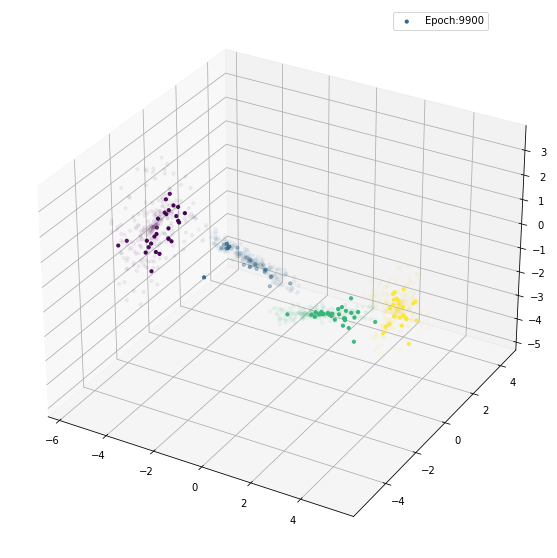

None

In [48]:
wgan.train(dataset,10000)

In [49]:
#IT WILL CREATE ANIMATED GIF OUT OF THE SAVED IMAGES
import imageio
import glob
anim_file = 'wgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('images/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)